<link rel="stylesheet" type="text/css" href="./style.css">

<div class="tutorial-header">

## Tutorial \#4: Graph Editor

</div>

<link rel="stylesheet" type="text/css" href="./style.css">

<div class="tutorial-text">

As we saw in the previous tutorial, <b>spark.nn.Brain</b> is a different, yet powerful, abstraction that allow us to build complex model architectures. However, as we also saw in that example, this process can be somewhat verbose (an even tedious!), even for simple models.

<b><i>Spark</i></b> was designed with this problem in mind: a lot of the time models are quite easy to express as diagrams but hard to code due to its recurrent nature, even more if we want the model to be efficient. In <b><i>Spark</i></b> we wanted to capitalize from this small observation, to reduce the friction of model building. Let there be graphic interfaces.

The <b>spark.GraphEditor</b> is a light-weight graphic interface packed with <b><i>Spark</i></b> that allows to design and configure models throw flow diagrams. Note that the editor can be either used from the CLI or a notebook, both options are equally viable, you only need to create a <b>spark.GraphEditor</b> object and launch it.

</div>

In [ ]:
# Imports
import spark
import jax.numpy as jnp

editor = spark.GraphEditor()
if __name__ == "__main__":		# <--- Good practice when initializing an application
	editor.launch()

<link rel="stylesheet" type="text/css" href="./style.css">

<div class="tutorial-text">

First, lest take a look at the Graph Editor interface.

![panels](../images/graph_editor_panels.png)

The graph graph editor is composed of five core elements:

1. <b>Graph Canvas</b>, this is the main componenet of the editor and where we create the model architecture by draging and dropping connections between the modules (nodes). You can use right click to add nodes to the canvas and 'del' to remove nodes from it.<br><br>
2. <b>Inspector</b>, the inspector is used, as it name suggest, the details of each module, we can perform simple parameter updates in this section. <br><br>
3. <b>Node List</b>, is used to indicate (and also select) every node in the current working space. <br><br>
4. <b>Console</b>, displays information and errors about the operations that we performed. <br><br>
5. <b>Menu Bar</b>, similar to any other program. Observe that there are two different types of saves/loads: "session" (.sge) and "model" (.scfg). Session is the standard way to save your progess when using the graph editor as it does not perform any type of validation on the current model; on the other hand, models is use to create a serialized version of a <b>spark.nn.BrainConfig</b> instance that can be later loaded in a regular python script.<br><br>

So far so good. Let's now load an already made model "example_ab_model.scfg" (available in the tutorial sections in the repository) to have a better grasp of the workload in the graph editor.

![panels](../images/graph_editor_details.png)

Everything in the editor works by adding nodes and connections among them; it is as simple as dragging one port to another!.

Now, whenever we select a node (singular) we can see the details of the associated module in the inspector and change them as we please. The header in the inspector displays the name that is going to be assigned to that node, the class of the node and a small picture of the structure of its configuration class.

The body of the inspector displays the fields of such configurations class, here is where we can update parameters. To the left of some parameters, you can see a small blackbox, clicking it will link the updates of similar variables (child variables with the same name); this is specially useful when you need to propagate parameters across the configuration hierarchy.

Currently, we can only support simple parameter assignements; nonetheless perform surgical parameter updates once you load the configuration from the class.  

After you are done editing your model, you are ready to export it and load it in any python script.

NOTE: Currently, we only recommend using the Graph Editor with entire neuronal models, due to the inner workings of <b>spark.nn.Brain</b> components can induce on a larger memory footprint and introduce a more latency than desired.

</div>

In [2]:
# Initialize BrainConfig from a .scfg file
brain_config = spark.nn.BrainConfig.from_file('example_ab_model.scfg')

# Initialize the Brain instance
brain = spark.nn.Brain(config=brain_config)

# Build the brain.
brain(drive=spark.FloatArray(jnp.zeros((4,), dtype=jnp.float16)))

{'action': FloatArray(value=Array([0., 0.], dtype=float16))}

<link rel="stylesheet" type="text/css" href="./style.css">

<div class="tutorial-text">

Since we are going to use the example file for the remaining of this tutorial let's take a second to study the model.

![panels](../images/graph_editor_explanation.png)

The first thing we need to identify are the input and the output variables, at each extreme of the canvas; <b>spark.nn.Brain</b> enforces the existence of at least on of each (boring models are not allowed!).

At the start, the input node feeds it's information to a <b>spark.nn.interfaces.TopologicalLinearSpiker</b> that transform a continuous signal to a stream of spikes.

Next, this new stream of spikes is feed to two different populations A & B of neurons, but only to the excitatory units of that population. In turn the excitatory units form connections with its respective inhibitory neurons and themselves. The twist is now that the inhibitory units of each population act only on the excitatory population of the other group. This architectural design bias the model towards a natural competition between A and B. 

Now, the output of the model is computed using each of the excitatory populations of A & B that incides onto the integrator. In a nutshell, this integrator graphs each population and computes on float for each of the populations that can be thought as the mean activity of these populations. Finally, this is passed to the output node to indicate that this new payload is actually the output of the brain. 

Now let's test this puppy in the same CartPole problem!.
</div>

But first, we need to repeat ourselves a little bit.

In [3]:
# Auxiliary functions

import jax
import numpy as np

# Utility function to execute brain efficiently.
@jax.jit
def run_model(graph, state, x):
	model = spark.merge(graph, state)
	out = model(drive=x)
	_, state = spark.split((model))
	return out, state

# Utility function to retrieve data from the model.
@jax.jit
def retrieve_spikes(graph, state,):
	model = spark.merge(graph, state)
	spikes = model.get_spikes_from_cache()
	return spikes

# Utility function to preprocess information from the environment.
def process_obs(x):
	# CartPos, CartSpeed, PoleAngle, PoleAngSpeed 
	x = x / np.array([2.4, 2.5, 0.2095, 3.5])
	x = np.clip(x, a_min=-1, a_max=1)
	return x

# Reward function.
def compute_real_reward(x, x_prev, r_prev, terminated):
	# CartPos, CartSpeed, PoleAngle, PoleAngSpeed 
	if terminated:
		return 0
	r = (x_prev[0]**2 - x[0]**2) + (x_prev[2]**2 - x[2]**2)
	r = np.clip(0.5 * r_prev + 2 * r, a_min=-1, a_max=1)
	return r

# Prepare the virtual environment
import gymnasium as gym
import ale_py
import numpy as np

from tqdm import tqdm
gym.register_envs(ale_py)

env_name =  'CartPole-v1'
env = gym.make(env_name)
next_obs, _ = env.reset(seed=42)
next_obs = process_obs(next_obs)

And we are ready to go

In [4]:
# Split brain into the graph and the state
graph, state = spark.split((brain))

# Some classic training loop.
reward = 0
for i in tqdm(range(2500)):
	prev_obs = next_obs
	# Model logic
	out, state = run_model(graph, state, spark.FloatArray(jnp.array(next_obs, dtype=jnp.float16)))
	# Environment logic.
	next_action = int(np.argmax(out['action'].value))
	next_obs, _, terminated, truncated, info = env.step(next_action)
	if terminated:
		next_obs, _ = env.reset()
		# Flush model. Although this is not strictly necessary cartpole scenarios are quite short,
		# so we pass a zero vector for a few timesteps to let the model "cooldown" a little bit.
		for i in range(16):
			_, state = run_model(graph, state, spark.FloatArray(jnp.zeros_like(next_obs, dtype=jnp.float16)))
	next_obs = process_obs(next_obs)
	reward = compute_real_reward(next_obs, prev_obs, reward, terminated)

100%|██████████| 2500/2500 [00:04<00:00, 535.53it/s]


<link rel="stylesheet" type="text/css" href="./style.css">

<div class="tutorial-text">

Now let's visualize what this brain is doing!
</div>

In [5]:
outs = []
spikes = []
obs = []
breaks = []
break_obs = []
actions = []
reward = 0
next_obs, _ = env.reset(seed=42+1)
next_obs = process_obs(next_obs)
brain_steps_per_env_step = 16
for i in tqdm(range(100)):
	prev_obs = next_obs
	# Model logic
	for _ in range(brain_steps_per_env_step):
		out, state = run_model(graph, state, spark.FloatArray(jnp.array(next_obs, dtype=jnp.float16)))
		outs.append(out['action'].value)
		model_spikes = retrieve_spikes(graph, state)
		spikes.append(
			jnp.concatenate([
				model_spikes['spiker'].value.reshape(-1),
				model_spikes['A_ex'].value.reshape(-1),
				model_spikes['A_in'].value.reshape(-1),
				model_spikes['B_ex'].value.reshape(-1),
				model_spikes['B_in'].value.reshape(-1),

			])
		)
		# Environment logic.
		next_action = int(np.argmax(out['action'].value))
		actions.append(next_action)
	next_obs, _, terminated, truncated, info = env.step(next_action)
	if terminated:
		break_obs.append(next_obs)
		next_obs, _ = env.reset()
		breaks.append(brain_steps_per_env_step*i)
		# Flush model
		for i in range(50):
			_, state = run_model(graph, state, spark.FloatArray(jnp.zeros_like(next_obs, dtype=jnp.float16)))
	next_obs = process_obs(next_obs)
	reward = compute_real_reward(next_obs, prev_obs, reward, terminated)
	obs.append(next_obs)
	
model = spark.merge(graph, state)
spikes = np.abs(np.array(spikes))

100%|██████████| 100/100 [00:01<00:00, 55.46it/s]


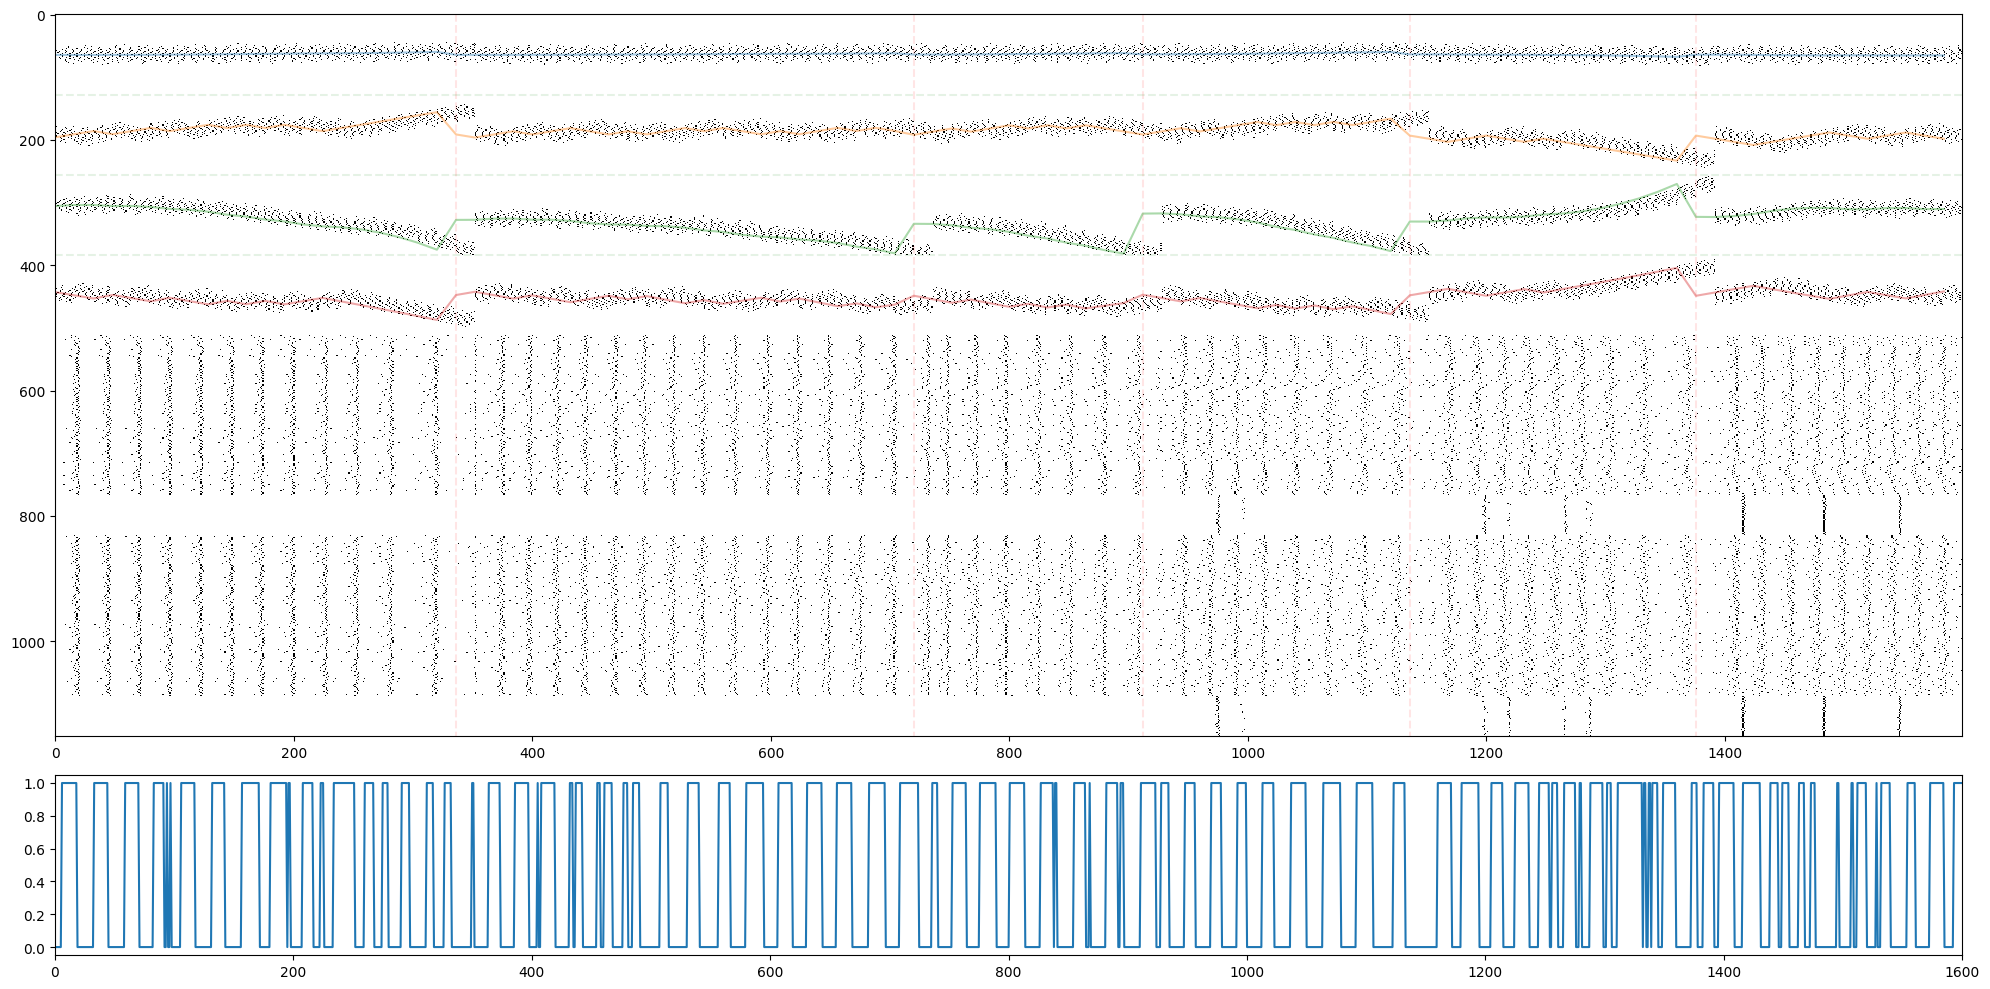

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1,figsize=(20,10), height_ratios=(8,2))
ax[0].imshow(1-spikes.T, cmap='gray', aspect='auto', interpolation='none')
for b in breaks:
    ax[0].plot([b,b], [0-0.5,spikes.shape[1]-0.5], 'r--', alpha=0.1)
for i in range(3):
    ax[0].plot([0-0.5,len(spikes)-0.5], [128*(i+1), 128*(i+1)], 'g--', alpha=0.1)
ax[0].plot(brain_steps_per_env_step*np.arange(len(spikes)//brain_steps_per_env_step), 64*np.array(obs).T[0]+64, alpha=0.4)
ax[0].plot(brain_steps_per_env_step*np.arange(len(spikes)//brain_steps_per_env_step), 64*np.array(obs).T[1]+64+128, alpha=0.4)
ax[0].plot(brain_steps_per_env_step*np.arange(len(spikes)//brain_steps_per_env_step), 64*np.array(obs).T[2]+64+256, alpha=0.4)
ax[0].plot(brain_steps_per_env_step*np.arange(len(spikes)//brain_steps_per_env_step), 64*np.array(obs).T[3]+64+128+256, alpha=0.4)
ax[1].plot(actions)
ax[1].set_xlim(0, len(actions))
plt.tight_layout()
plt.show()